# Table of Contents
 <p>

In [18]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')
%matplotlib inline
import h5py

import seaborn as sns

from __future__ import print_function

from keras.models import Sequential
from keras.layers import Convolution1D, Convolution2D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout, Flatten

In [7]:
# test data
filename_data = "testdata.h5"
dir_data = "data001/"

# sim data
filename_data = "apogee-spectra.h5"
dir_data = "data002/"


In [22]:
dir_base = "/Users/nord/Dropbox/TheCNNon/"
dir_model = "../data/"
dir_data_full = dir_base + dir_data
file_data = dir_data_full + filename_data
file_model = dir_model + "model.json"
file_weights = dir_model + "weights.h5"

In [12]:
# open and normalize data
with h5py.File(file_data, 'r') as f:
    X = f['X'][:]#.astype(np.float32)
    y = f['y'][:]#.astype(np.float32)

y = y[:,0:1]
temperature_min = min(y)
y = y - temperature_min
temperature_minmax = max(y)
y = y / temperature_minmax

print("min and intermediate max")
print(temperature_min, temperature_minmax)
print(min(y), max(y))

# remove nans
X[np.isnan(X)] = 0.

min and intermediate max
[ 3650.7] [ 2104.9]
[ 0.] [ 1.]


In [14]:
# shuffle
idx = np.random.choice(len(X), size=len(X), replace=False)
X = X[idx]
y = y[idx]

In [15]:
# set main training parameters
n_train = 2048
n_valid = 1024
nb_epoch = 30
#n_test = X.shape[0] - n_train - n_valid
n_test = 2048
print("Train, Valid, Test", n_train, n_valid, n_test)

Train, Valid, Test 2048 1024 2048


In [16]:
# split data
X_train = X[:n_train]
y_train = y[:n_train,:1]

X_valid = X[n_train:n_train+n_valid]
y_valid = y[n_train:n_train+n_valid,:1]

X_test = X[n_train+n_valid:]
y_test = y[n_train+n_valid:,:1]
n_objects, n_pixels = X_train.shape
n_objects, n_pixels


(2048, 8575)

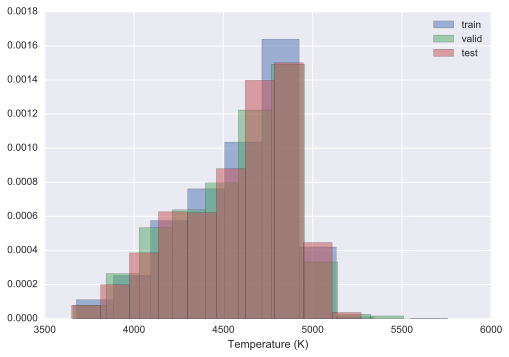

In [19]:
y_train_temp = (y_train* temperature_minmax) + temperature_min
y_valid_temp = (y_valid* temperature_minmax) + temperature_min
y_test_temp = (y_test* temperature_minmax) + temperature_min

plt.hist(y_train_temp, alpha=0.5, normed=True, label='train');
plt.hist(y_valid_temp, alpha=0.5, normed=True, label='valid');
plt.hist(y_test_temp, alpha=0.5, normed=True, label='test');
plt.xlabel('Temperature (K)')
plt.legend()

In [27]:
# define model
model = Sequential()

model.add(Convolution1D(nb_filter=128, filter_length=32, input_dim=1))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_length=32))


model.add(Convolution1D(nb_filter=128, filter_length=16, input_dim=1))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_length=16))


model.add(Convolution1D(nb_filter=128, filter_length=8, input_dim=1))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_length=8))

#model.add(Convolution1D(nb_filter=128, filter_length=2, input_dim=1))
#model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_length=2))

# We add a vanilla hidden layer:
# model.add(Dense(128))
# model.add(Dropout(0.5))

model.add(Dense(96))
model.add(Dropout(0.50))
#model.add(Activation('sigmoid'))

model.add(GlobalMaxPooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))

optimizer = 'adadelta'
#optimizer="rmsprop"
model.compile(loss="mse", optimizer=optimizer)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_10 (Convolution1D) (None, None, 128)     4224        convolution1d_input_4[0][0]      
____________________________________________________________________________________________________
activation_10 (Activation)       (None, None, 128)     0           convolution1d_10[0][0]           
____________________________________________________________________________________________________
maxpooling1d_10 (MaxPooling1D)   (None, None, 128)     0           activation_10[0][0]              
____________________________________________________________________________________________________
convolution1d_11 (Convolution1D) (None, None, 128)     262272      maxpooling1d_10[0][0]            
___________________________________________________________________________________________

In [28]:
history = model.fit(X_train.reshape(len(X_train), n_pixels, 1), y_train, nb_epoch=nb_epoch, batch_size=32,
          validation_data=(X_valid.reshape(len(X_valid), n_pixels, 1), y_valid), verbose=True)

Train on 2048 samples, validate on 1024 samples
Epoch 1/30
2048/2048 [==============================] - 27s - loss: 0.0426 - val_loss: 0.0304

In [20]:
# History
hist = history.history
loss = hist['loss']
val_loss = hist["val_loss"]
epochs = np.arange(nb_epoch)
figsize=(5,3)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="val loss")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Loss History")
plt.tight_layout()
axis1.legend(loc='upper right')


NameError: name 'history' is not defined

In [26]:
from keras.models import model_from_json
json_file = open(file_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(file_weights)

In [27]:
y_pred = model.predict(X_test.reshape(len(X_test), n_pixels, 1), verbose=True)

1024/1024 [==============================] - 8s      

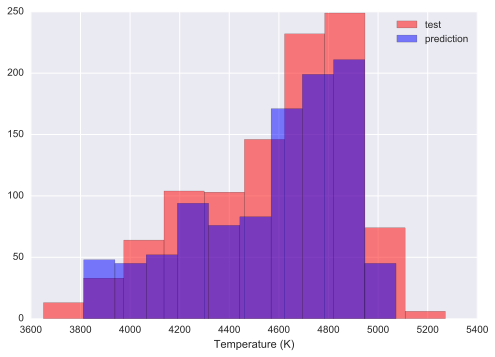

In [32]:
y_test_temp = (y_test* temperature_minmax) + temperature_min
y_pred_temp = (y_pred* temperature_minmax) + temperature_min

plt.hist(y_test_temp, color='red', alpha=0.5, label="test");# bins = bins);
plt.hist(y_pred_temp, color='blue', alpha=0.5, label="prediction");# bins=bins);
plt.legend()
plt.xlabel("Temperature (K)")

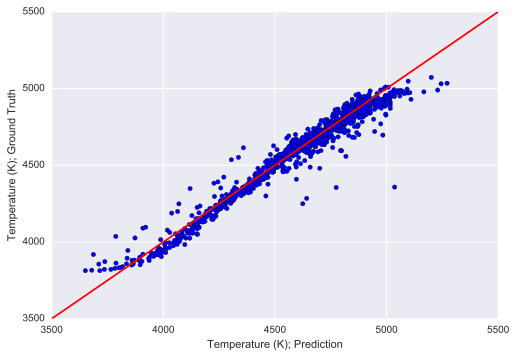

In [42]:
plt.scatter(y_test_temp,y_pred_temp)
min_temp = min(min(y_test_temp), min(y_pred_temp))
max_temp = max(max(y_test_temp), max(y_pred_temp))

xline = yline  = np.linspace(min_temp*0.2, max_temp*2, 2)
plt.plot(xline,yline,color='red')
plt.xlim(3500, 5500)
plt.ylim(3500, 5500)
plt.xlabel("Temperature (K); Prediction")
plt.ylabel("Temperature (K); Ground Truth")

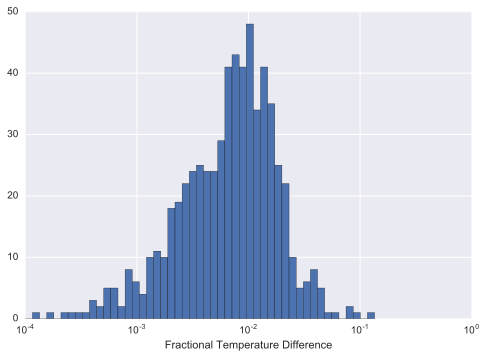

In [46]:
data  =(y_test_temp-y_pred_temp)/y_test_temp#), bins='auto');
plt.hist(data, bins=np.logspace(-4, max(np.log10(data)), 50))
plt.gca().set_xscale("log")
plt.xlabel('Fractional Temperature Difference')

In [34]:
f_model = "./model.json"
f_weights = "./weights.h5"
model.save_weights(f_weights)
open(f_model, 'w').write(model.to_json())